<a href="https://colab.research.google.com/github/Wabinab/hackqthon_team27/blob/main/FourthTrial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit

     |████████████████████████████████| 6.0MB 7.3MB/s 
     |████████████████████████████████| 18.0MB 187kB/s 
     |████████████████████████████████| 235kB 52.0MB/s 
     |████████████████████████████████| 215kB 57.9MB/s 
     |████████████████████████████████| 2.1MB 43.4MB/s 
     |████████████████████████████████| 1.0MB 36.8MB/s 
     |████████████████████████████████| 51kB 9.3MB/s 
     |████████████████████████████████| 194kB 55.3MB/s 
     |████████████████████████████████| 112kB 54.5MB/s 
     |████████████████████████████████| 614kB 45.4MB/s 
     |████████████████████████████████| 3.2MB 44.5MB/s 
     |████████████████████████████████| 6.3MB 40.7MB/s 
  Created wheel for qiskit: filename=qiskit-0.26.2-cp37-none-any.whl size=10491 sha256=666e1fd749f97a682396d19c5a25326091c9fbb38b8c3cf918598c55047db16d
  Stored in directory: /root/.cache/pip/wheels/89/89/34/524839952d5a58a7be9789e580bfc1ca883bf6579152444568
  Created wheel for python-constraint: filename=python_constraint-1.4.0-

In [2]:
import qiskit
from qiskit import *
from qiskit.compiler import assemble
from qiskit.visualization import plot_histogram


import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm import tqdm

In [13]:
shots = 4000
number = 4
equality = shots / np.power(2, number)

In [68]:
Dataset_size = 2048
backend = Aer.get_backend('qasm_simulator')

df = pd.DataFrame()

for i in tqdm(range(Dataset_size)):
    
    qc = QuantumCircuit(number, number)

    rng = np.random.default_rng()
    
    random_value = []

    for i in range(number):
        inside_random = [rng.random() * np.pi for i in range(3)]
        qc.rx(inside_random[0], i)
        qc.ry(inside_random[1], i)
        qc.rz(inside_random[2], i)
        
        random_value = np.concatenate((random_value, inside_random))

    qc.measure(range(number), range(number))
    circ = transpile(qc, backend)

    qobj = assemble(circ, shots=shots)

    # Run and get counts
    result = backend.run(qobj).result()
    counts = result.get_counts()
    
    df_temp = pd.DataFrame(counts, index=[i])
    
    for i in range(number * 3):
        df_temp[f"target_{i}"] = [random_value[i]]
    
    df = df.append(df_temp)
    
    

100%|██████████| 2048/2048 [00:54<00:00, 37.51it/s]


In [69]:
copied_df = df.copy()

# copied_df = (copied_df - copied_df.min()) / (copied_df.max() - copied_df.min())
train_mean = copied_df.mean()
train_std = copied_df.std()

copied_df = (copied_df - train_mean) / train_std

# Replace all nan with 0
copied_df = copied_df.fillna(0)

copied_df.head()

,0010,0011,0000,0111,1001,1011,1101,0110,0100,1110,1000,0001,0101,1100,1010,1111,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11
3,-0.501552,-0.544240,-0.326182,-0.559762,0.606413,0.046723,0.612794,-0.575505,-0.226799,0.126753,0.764865,-0.351582,-0.379472,0.868167,0.164312,-0.003416,-1.125179,-0.096933,-0.247424,-1.412077,-0.334593,-1.679524,0.038427,-1.665409,-0.916450,1.289488,-0.632902,-1.503149
3,-0.148173,2.597203,-0.319593,1.516007,-0.562863,-0.528980,-0.656767,-0.279782,-0.498350,-0.786893,-0.777965,1.613023,0.870405,-0.845428,-0.739046,-0.547400,-1.430228,0.780582,1.510446,-0.312248,0.573721,-1.138797,-0.180041,-1.358540,0.886665,-1.510330,-1.008921,-1.545038
3,1.108655,-0.014399,0.085621,0.113460,-0.642082,-0.522126,-0.643368,1.630522,0.438832,0.322534,-0.485989,-0.497240,-0.355502,-0.355830,-0.041145,-0.382139,-1.742204,-0.484512,1.166919,1.128968,-0.532727,-0.908971,-0.216565,0.878581,-0.302743,-1.380963,-0.432370,-1.072903
3,-0.801590,-0.766431,-0.757751,-0.137348,-0.524838,-0.662625,2.739897,-0.340966,0.031505,0.133622,-0.718243,-0.756582,0.932043,1.116414,-0.771659,1.136196,-1.223831,0.373700,-0.908919,1.269736,0.323561,0.098286,1.558154,-1.113717,0.282960,0.587915,-0.969978,-1.099384
3,-0.174843,-0.065674,0.029616,-0.520161,0.793370,0.711522,-0.130854,-0.551711,-0.531466,-0.319766,0.804680,0.156444,-0.468504,-0.228258,0.490434,-0.296065,-0.096641,0.571975,0.785265,-1.351434,-0.160765,-0.023088,-0.793584,-0.706839,-0.822727,1.760039,-0.365827,1.215943


In [70]:
# Check if there are any NaNs. 
copied_df.isnull().values.any()

False

In [71]:
batch_size = 1

target = copied_df.iloc[:, -3 * number:]
df = copied_df.iloc[:, :-3 * number]

# target = df.pop("target")
dataset = tf.data.Dataset.from_tensor_slices((df.values, target.values))

train_dataset = dataset.cache().shuffle(len(df)).batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [72]:
Dense = tf.keras.layers.Dense

tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    Dense(3 * number, input_shape=(len(df.columns), ), activation=tf.nn.relu),
    Dense(1024, activation=tf.nn.relu),
    Dense(256, activation=tf.nn.relu),
    Dense(3 * number, activation=tf.nn.sigmoid)
])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss="mean_squared_error")

model.fit(train_dataset, epochs=10,)

Epoch 1/10
2048/2048 [==============================] - 4s 2ms/step - loss: 1.4998
Epoch 2/10
2048/2048 [==============================] - 4s 2ms/step - loss: 1.4995
Epoch 3/10
2048/2048 [==============================] - 4s 2ms/step - loss: 1.4995
Epoch 4/10
2048/2048 [==============================] - 4s 2ms/step - loss: 1.4995
Epoch 5/10
2048/2048 [==============================] - 4s 2ms/step - loss: 1.4995
Epoch 6/10
2048/2048 [==============================] - 4s 2ms/step - loss: 1.4995
Epoch 7/10
2048/2048 [==============================] - 4s 2ms/step - loss: 1.4995
Epoch 8/10
2048/2048 [==============================] - 4s 2ms/step - loss: 1.4995
Epoch 9/10
2048/2048 [==============================] - 4s 2ms/step - loss: 1.4995
Epoch 10/10
2048/2048 [==============================] - 4s 2ms/step - loss: 1.4995


In [121]:
value_this = np.rint(np.random.dirichlet(np.ones(16), size=1) * shots)
# value_this = np.reshape([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, shots], (1, 16))
new_val = (value_this - train_mean[:-3 * number].values) / train_std[:-3 * number].values

In [122]:
pred = model.predict(new_val)
pred = (pred * train_std[-3 * number:].values) + train_mean[-3 * number:].values
pred = np.squeeze(pred)

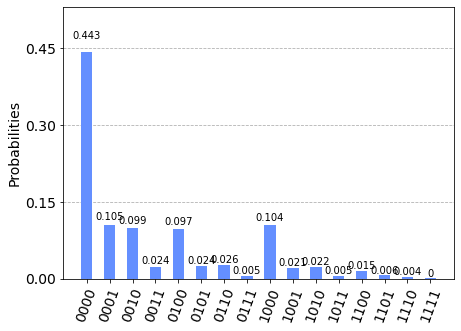

In [123]:
qc = QuantumCircuit(number, number)

for i in range(number):
    qc.rx(pred[0 * (i + 1)], i)
    qc.ry(pred[0 * (i + 2)], i)
    qc.rz(pred[0 * (i + 3)], i)

qc.measure(range(number), range(number))
circ = transpile(qc, backend)

qobj = assemble(circ, shots=shots)

# Run and get counts
result = backend.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

In [124]:
pred

array([2.49347505, 2.47280132, 2.51305636, 1.53896315, 2.53338271,
       1.57226614, 2.45784733, 1.52983895, 1.5794965 , 1.55878848,
       2.47334759, 1.55470769])

In [138]:
names = ['{0:04b}'.format(i) for i in range(2 ** number)]
pred_df = pd.DataFrame(value_this, columns = names)

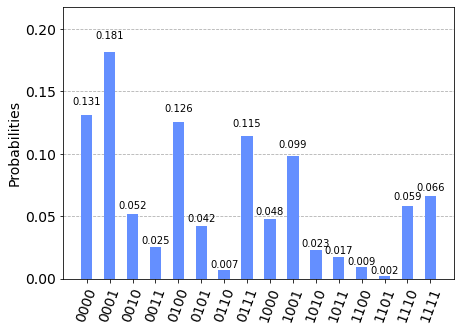

In [140]:
plot_histogram(pred_df.to_dict("records"))

In [141]:
diff = 0
value_this = np.squeeze(value_this)
for key, value in counts.items():
  diff += abs(value_this[int(key, 2)] - value)

print(diff)

3548.0
